# Comparative Acquisition of Complex Sentence Structures in Bilingual and Monolingual Children

## 1. Load all datasets

The project contains multiple CHILDES datasets organized as follows:

1. **English-MiamiBiling/**: Bilingual English data (2 & 5-year-olds, audio/no-audio)
2. **English-MiamiMono/**: Monolingual English data (2 & 5-year-olds)  
3. **Spanish-MiamiBiling/**: Bilingual Spanish data (2 & 5-year-olds, audio/no-audio)
4. **Hoff/**: Additional dataset with English/Spanish bilingual and monolingual data (age groups 2.5, 3, 3.5)

In [1]:

import pylangacq as pla
import os
import glob
import pandas as pd

In [2]:
def robust_load_cha(file_path):
    """
    Robust function to load .cha files with fallback strategies
    Returns: (success, chat_object_or_utterance_count, method_used)
    """
    
    # Strategy 1: Try normal pylangacq loading
    try:
        chat = pla.read_chat(file_path)
        return True, chat, 'pylangacq'
    except Exception as e1:
        # Strategy 2: Try with explicit encoding
        try:
            chat = pla.read_chat(file_path, encoding='utf-8')
            return True, chat, 'pylangacq_utf8'
        except Exception as e2:
            # Strategy 3: Raw parsing for basic utterance count
            try:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    content = f.read()
                lines = content.split('\n')
                chi_utterances = [line for line in lines if line.strip().startswith('*CHI:')]
                return False, chi_utterances, 'raw_parsing'
            except Exception as e3:
                return False, 0, 'failed'

def load_directory_structure():
    """
    Comprehensively load all .cha files from all directories
    """
    
    # Define all dataset directories
    datasets = {
        'English-MiamiBiling': {
            'bleng2-audio': 'English_Bilingual_Age2_Audio',
            'bleng2-noaudio': 'English_Bilingual_Age2_NoAudio', 
            'bleng5-audio': 'English_Bilingual_Age5_Audio',
            'bleng5-noaudio': 'English_Bilingual_Age5_NoAudio'
        },
        'English-MiamiMono': {
            'mleng2': 'English_Monolingual_Age2',
            'mleng5': 'English_Monolingual_Age5'
        },
        'Spanish-MiamiBiling': {
            'blspan2-audio': 'Spanish_Bilingual_Age2_Audio',
            'blspan2-noaudio': 'Spanish_Bilingual_Age2_NoAudio',
            'blspan5-audio': 'Spanish_Bilingual_Age5_Audio', 
            'blspan5-noaudio': 'Spanish_Bilingual_Age5_NoAudio'
        },
        'Hoff': {
            'biling-eng/2.5': 'Hoff_Bilingual_English_Age2.5',
            'biling-eng/3': 'Hoff_Bilingual_English_Age3',
            'biling-eng/3.5': 'Hoff_Bilingual_English_Age3.5',
            'biling-spa/2.5': 'Hoff_Bilingual_Spanish_Age2.5',
            'biling-spa/3': 'Hoff_Bilingual_Spanish_Age3',
            'biling-spa/3.5': 'Hoff_Bilingual_Spanish_Age3.5',
            'mono/2.5': 'Hoff_Monolingual_Age2.5',
            'mono/3': 'Hoff_Monolingual_Age3',
            'mono/3.5': 'Hoff_Monolingual_Age3.5'
        },

        'Spanish-Ornat':{
            '03': 'Spanish_Ornat_Monolingual_Age3',
            '04': 'Spanish_Ornat_Monolingual_Age4',
        },
        
        'Spanish-Sebastian':{
            '03': 'Spanish_Sebastian_Monolingual_Age3',
            '04': 'Spanish_Sebastian_Monolingual_Age4'
   
        }
    }
    
    all_datasets = {}
    summary_stats = []
    
    print("Loading all datasets...")
    print("=" * 60)
    
    for main_dir, subdirs in datasets.items():
        for subdir, dataset_name in subdirs.items():
            dir_path = os.path.join(main_dir, subdir)
            
            if not os.path.exists(dir_path):
                print(f"⚠️  Directory not found: {dir_path}")
                continue
                
            # Find all .cha files
            cha_files = glob.glob(os.path.join(dir_path, "*.cha"))
            
            if not cha_files:
                print(f"📁 {dataset_name}: No .cha files found")
                continue
            
            # Load files
            dataset_files = []
            successful_loads = 0
            partial_loads = 0
            failed_loads = 0
            
            for file_path in cha_files:
                success, result, method = robust_load_cha(file_path)
                
                file_info = {
                    'filename': os.path.basename(file_path),
                    'filepath': file_path,
                    'dataset': dataset_name,
                    'main_category': main_dir,
                    'subcategory': subdir,
                    'success': success,
                    'method': method
                }
                
                if success:
                    file_info['chat_object'] = result
                    file_info['participants'] = result.participants()
                    file_info['utterance_count'] = len(result.utterances())
                    successful_loads += 1
                elif method == 'raw_parsing':
                    file_info['utterance_count'] = len(result)
                    file_info['chi_utterances'] = result
                    partial_loads += 1
                else:
                    failed_loads += 1
                
                dataset_files.append(file_info)
            
            # Store dataset
            all_datasets[dataset_name] = dataset_files
            
            # Print summary
            total_files = len(cha_files)
            print(f"📊 {dataset_name}")
            print(f"   Total files: {total_files}")
            print(f"   ✅ Fully loaded: {successful_loads}")
            print(f"   🔶 Partial (raw): {partial_loads}")
            print(f"   ❌ Failed: {failed_loads}")
            print()
            
            # Add to summary stats
            summary_stats.append({
                'dataset': dataset_name,
                'main_category': main_dir,
                'subcategory': subdir,
                'total_files': total_files,
                'successful': successful_loads,
                'partial': partial_loads,
                'failed': failed_loads,
                'success_rate': (successful_loads / total_files * 100) if total_files > 0 else 0
            })
    
    return all_datasets, pd.DataFrame(summary_stats)

In [34]:
all_data, summary_df = load_directory_structure()

Loading all datasets...
📊 English_Bilingual_Age2_Audio
   Total files: 21
   ✅ Fully loaded: 12
   🔶 Partial (raw): 9
   ❌ Failed: 0

📊 English_Bilingual_Age2_NoAudio
   Total files: 66
   ✅ Fully loaded: 33
   🔶 Partial (raw): 33
   ❌ Failed: 0

📊 English_Bilingual_Age5_Audio
   Total files: 16
   ✅ Fully loaded: 7
   🔶 Partial (raw): 9
   ❌ Failed: 0

📊 English_Bilingual_Age5_NoAudio
   Total files: 73
   ✅ Fully loaded: 47
   🔶 Partial (raw): 26
   ❌ Failed: 0

📊 English_Monolingual_Age2
   Total files: 43
   ✅ Fully loaded: 19
   🔶 Partial (raw): 24
   ❌ Failed: 0

📊 English_Monolingual_Age5
   Total files: 46
   ✅ Fully loaded: 29
   🔶 Partial (raw): 17
   ❌ Failed: 0

📊 Spanish_Bilingual_Age2_Audio
   Total files: 19
   ✅ Fully loaded: 13
   🔶 Partial (raw): 6
   ❌ Failed: 0

📊 Spanish_Bilingual_Age2_NoAudio
   Total files: 68
   ✅ Fully loaded: 30
   🔶 Partial (raw): 38
   ❌ Failed: 0

📊 Spanish_Bilingual_Age5_Audio
   Total files: 16
   ✅ Fully loaded: 11
   🔶 Partial (raw): 5


In [35]:
# Display comprehensive summary
print("\n" + "="*80)
print("📈 COMPREHENSIVE DATASET SUMMARY")
print("="*80)

# Overall statistics
total_datasets = len(all_data)
total_files = sum(len(files) for files in all_data.values())
total_successful = summary_df['successful'].sum()
total_partial = summary_df['partial'].sum() 
total_failed = summary_df['failed'].sum()

print(f"📁 Total datasets: {total_datasets}")
print(f"📄 Total files: {total_files}")
print(f"✅ Fully loaded: {total_successful} ({total_successful/total_files*100:.1f}%)")
print(f"🔶 Partially loaded: {total_partial} ({total_partial/total_files*100:.1f}%)")
print(f"❌ Failed: {total_failed} ({total_failed/total_files*100:.1f}%)")
print(f"📊 Overall success rate: {(total_successful+total_partial)/total_files*100:.1f}%")

print("\n" + "="*80)
print("📋 DETAILED BREAKDOWN BY DATASET")
print("="*80)

# Sort by main category for better organization
summary_df_sorted = summary_df.sort_values(['main_category', 'subcategory'])
print(summary_df_sorted.to_string(index=False))

print("\n" + "="*80)
print("🔍 DATASET ACCESS EXAMPLES")
print("="*80)

# Show examples of how to access data
for dataset_name, files in list(all_data.items())[:3]:  # Show first 3 datasets
    print(f"\n📚 {dataset_name}:")
    print(f"   Access: all_data['{dataset_name}']")
    print(f"   Files: {len(files)}")
    
    if files:
        # Show example file
        example_file = files[0]
        print(f"   Example file: {example_file['filename']}")
        if example_file['success']:
            print(f"   Participants: {example_file['participants']}")
            print(f"   Utterances: {example_file['utterance_count']}")
        else:
            print(f"   Utterances (raw): {example_file.get('utterance_count', 'N/A')}")


📈 COMPREHENSIVE DATASET SUMMARY
📁 Total datasets: 23
📄 Total files: 853
✅ Fully loaded: 646 (75.7%)
🔶 Partially loaded: 207 (24.3%)
❌ Failed: 0 (0.0%)
📊 Overall success rate: 100.0%

📋 DETAILED BREAKDOWN BY DATASET
                           dataset       main_category     subcategory  total_files  successful  partial  failed  success_rate
      English_Bilingual_Age2_Audio English-MiamiBiling    bleng2-audio           21          12        9       0     57.142857
    English_Bilingual_Age2_NoAudio English-MiamiBiling  bleng2-noaudio           66          33       33       0     50.000000
      English_Bilingual_Age5_Audio English-MiamiBiling    bleng5-audio           16           7        9       0     43.750000
    English_Bilingual_Age5_NoAudio English-MiamiBiling  bleng5-noaudio           73          47       26       0     64.383562
          English_Monolingual_Age2   English-MiamiMono          mleng2           43          19       24       0     44.186047
          English_Mono

# Stijn

To do:
- Fix raw parse text
- Add that the correct language is used for each utterance (maybe only use a couple test for the spanish utterances)
- Add graphs and plots

In [24]:
import pandas as pd
import textstat
from tqdm import tqdm

# https://pypi.org/project/textstat/

# To switch languages:
language = 'en'  # example: 'en' for English, 'es' for Spanish

textstat.set_lang(language)

In [37]:
def get_plain_utterances_from_dataset(dataset, calc_scores=True):
    utterances_dictionary = {}   
    for file in tqdm(all_data[dataset]):
        plain_utterances = []
        if file['success'] == True:
            for ut in file['chat_object'].utterances():
                plain_utterances.append(' '.join([token.word for token in ut.tokens]))

                if calc_scores:
                    scores = [
                        file['dataset'],
                        file['filename'],
                        [textstat.flesch_reading_ease(x) for x in plain_utterances],
                        # [textstat.flesch_kincaid_grade(x) for x in plain_utterances],
                        # [textstat.smog_index(x) for x in plain_utterances],
                        # [textstat.coleman_liau_index(x) for x in plain_utterances],
                        # [textstat.automated_readability_index(x) for x in plain_utterances],
                        # [textstat.dale_chall_readability_score(x) for x in plain_utterances],
                        # [textstat.difficult_words(x) for x in plain_utterances],
                        # [textstat.linsear_write_formula(x) for x in plain_utterances],
                        # [textstat.gunning_fog(x) for x in plain_utterances],
                        # [textstat.text_standard(x) for x in plain_utterances],
                        [textstat.fernandez_huerta(x) for x in plain_utterances],
                        # [textstat.szigriszt_pazos(x) for x in plain_utterances],
                        # [textstat.gutierrez_polini(x) for x in plain_utterances],
                        # [textstat.crawford(x) for x in plain_utterances],
                        # [textstat.gulpease_index(x) for x in plain_utterances],
                        # [textstat.osman(x) for x in plain_utterances]
                    ]
                    
                    utterances_dictionary[file['filename']] = [plain_utterances, scores]
                else:
                    utterances_dictionary[file['filename']] = [plain_utterances]

    return utterances_dictionary

def utterances_all_files(datasets, calc_scores=True):
    total_utterances_dictionary = {}
    for dataset in datasets:
        utterances = get_plain_utterances_from_dataset(dataset, calc_scores=True)
        total_utterances_dictionary[dataset] = utterances

    return total_utterances_dictionary

In [38]:
all_utterances = utterances_all_files([x for x in summary_df['dataset']])
# all_utterances = utterances_all_files(["Hoff_Bilingual_English_Age2.5", "Hoff_Bilingual_English_Age3"])
# all_utterances = utterances_all_files(["English_Bilingual_Age2_Audio", "English_Bilingual_Age2_NoAudio", "English_Bilingual_Age5_Audio", "English_Bilingual_Age5_NoAudio", "English_Monolingual_Age2", "English_Monolingual_Age5"])

100%|██████████| 12/12 [00:00<00:00, 1332.86it/s]


In [39]:
all_utterances.keys()

dict_keys(['English_Bilingual_Age2_Audio', 'English_Bilingual_Age2_NoAudio', 'English_Bilingual_Age5_Audio', 'English_Bilingual_Age5_NoAudio', 'English_Monolingual_Age2', 'English_Monolingual_Age5', 'Spanish_Bilingual_Age2_Audio', 'Spanish_Bilingual_Age2_NoAudio', 'Spanish_Bilingual_Age5_Audio', 'Spanish_Bilingual_Age5_NoAudio', 'Hoff_Bilingual_English_Age2.5', 'Hoff_Bilingual_English_Age3', 'Hoff_Bilingual_English_Age3.5', 'Hoff_Bilingual_Spanish_Age2.5', 'Hoff_Bilingual_Spanish_Age3', 'Hoff_Bilingual_Spanish_Age3.5', 'Hoff_Monolingual_Age2.5', 'Hoff_Monolingual_Age3', 'Hoff_Monolingual_Age3.5', 'Spanish_Ornat_Monolingual_Age3', 'Spanish_Ornat_Monolingual_Age4', 'Spanish_Sebastian_Monolingual_Age3', 'Spanish_Sebastian_Monolingual_Age4'])

In [40]:
import csv
import json

csv_filename = "all_utterances.csv"
fieldnames = ['dataset', 'filename', 'plain_utterances', 'scores']

with open(csv_filename, mode='w', newline='', encoding='utf-8') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for dataset, files in all_utterances.items():
        # files is a dict: filename -> [plain_utterances, scores] (scores may be absent)
        for filename, value in files.items():
            plain = value[0] if len(value) > 0 else []
            scores = value[1] if len(value) > 1 else None
            writer.writerow({
                'dataset': dataset,
                'filename': filename,
                'plain_utterances': json.dumps(plain, ensure_ascii=False),
                'scores': json.dumps(scores, ensure_ascii=False)
            })

In [29]:
csv_filename = "all_utterances.csv"
data_df = pd.read_csv(csv_filename)
data_df["plain_utterances"] = [x.replace(', "', '').split('"')[1:-1] for x in data_df["plain_utterances"]]

In [30]:
kf_total = []
fh_total = []
lang_total = []

for file in tqdm(range(len(data_df))):
    kf_ease = []
    fh_ease = []
    languages = []
    for sentence in data_df['plain_utterances'][file]:

        try:
            lang = detect(sentence)
        except:
            lang = 'en'

        if lang == 'en':
            textstat.set_lang('en')

        elif lang == 'es':
            textstat.set_lang('es')

        else:
            textstat.set_lang('en')

        languages.append(lang)
        kf_ease.append(textstat.flesch_reading_ease(sentence))
        fh_ease.append(textstat.fernandez_huerta(sentence))

    kf_total.append(kf_ease)
    fh_total.append(fh_ease)
    lang_total.append(languages)


100%|██████████| 602/602 [00:07<00:00, 81.45it/s] 


In [31]:
kf_total_en = []
kf_total_sp = []
fh_total_en = []
fh_total_sp = []

for file in tqdm(range(len(data_df))):
    kf_ease_en = []
    fh_ease_en = []
    kf_ease_sp = []
    fh_ease_sp = []
    for sentence in data_df['plain_utterances'][file]:
        textstat.set_lang('en')
        kf_ease_en.append(textstat.flesch_reading_ease(sentence))
        fh_ease_en.append(textstat.fernandez_huerta(sentence))

        textstat.set_lang('es')
        kf_ease_sp.append(textstat.flesch_reading_ease(sentence))
        fh_ease_sp.append(textstat.fernandez_huerta(sentence))

    kf_total_en.append(kf_ease_en)
    kf_total_sp.append(kf_ease_sp)
    fh_total_en.append(fh_ease_en)
    fh_total_sp.append(fh_ease_sp)


100%|██████████| 602/602 [00:11<00:00, 54.16it/s] 


In [32]:
def most_common(lst):
    return max(set(lst), key=lst.count)

data_df['kf_ease_en'] = kf_total_en
data_df['fh_ease_en'] = fh_total_en
data_df['kf_ease_sp'] = kf_total_sp
data_df['fh_ease_en'] = fh_total_sp
# data_df['languages'] = lang_total 
data_df['kf_ease_avg_en'] = [sum(x)/len(x) for x in kf_total_en]
data_df['kf_ease_avg_sp'] = [sum(x)/len(x) for x in kf_total_sp]
data_df['fh_ease_avg_en'] = [sum(x)/len(x) for x in fh_total_en]
data_df['fh_ease_avg_sp'] = [sum(x)/len(x) for x in fh_total_sp]
# data_df['lang_most'] = [most_common(x) for x in lang_total]


In [16]:
#data_df.to_csv('Score_df.csv', index=False)

data_df = pd.read_csv('Score_df.csv')

In [33]:
data_df


,dataset,filename,plain_utterances,scores,kf_ease_en,fh_ease_en,kf_ease_sp,kf_ease_avg_en,kf_ease_avg_sp,fh_ease_avg_en,fh_ease_avg_sp
0,English_Bilingual_Age2_Audio,11221425.cha,[the boy and the dog were looking at the frog ...,"[""English_Bilingual_Age2_Audio"", ""11221425.cha...","[103.625, 115.13000000000002, 103.54, 116.1450...","[130.64000000000001, 139.7, 131.18, 130.72, 93...","[130.64000000000001, 139.7, 131.18, 130.72, 93...",100.113504,122.854049,128.804432,122.854049
1,English_Bilingual_Age2_Audio,11222222.cha,"[the boy went to sleep ., and the frog jumped ...","[""English_Bilingual_Age2_Audio"", ""11222222.cha...","[117.16000000000003, 103.70000000000002, 103.0...","[141.74, 124.32666666666665, 131.1285714285714...","[141.74, 124.32666666666665, 131.1285714285714...",107.633048,128.837270,134.322984,128.837270
2,English_Bilingual_Age2_Audio,11222306.cha,[one night the boy and the dog were looking at...,"[""English_Bilingual_Age2_Audio"", ""11222306.cha...","[103.00500000000001, 103.04428571428575, 103.7...","[124.60000000000001, 122.55714285714286, 124.3...","[124.6, 122.55714285714284, 124.32666666666665...",101.228104,122.826756,129.348600,122.826756
3,English_Bilingual_Age2_Audio,12122227.cha,"[the dog and the boy is sleeping ., the frog i...","[""English_Bilingual_Age2_Audio"", ""12122227.cha...","[103.04428571428575, 92.965, 80.30636363636367...","[131.12857142857143, 131.18, 108.3472727272727...","[131.12857142857143, 131.18, 108.3472727272727...",100.278569,117.334643,129.532460,117.334643
4,English_Bilingual_Age2_Audio,12222013.cha,"[there was this boy ., he got a a pet that's P...","[""English_Bilingual_Age2_Audio"", ""12222013.cha...","[118.17500000000001, 95.955, 90.99000000000004...","[127.76, 119.60000000000001, 83.78, 113.985714...","[127.75999999999999, 119.6, 83.78, 113.9857142...",90.425742,107.214236,113.723915,107.214236
...,...,...,...,...,...,...,...,...,...,...,...
597,Hoff_Monolingual_Age3.5,034.cha,"[purple !, oh ., Dalia has it !, that's POSTCL...","[""Hoff_Monolingual_Age3.5"", ""034.cha"", [36.620...","[36.62000000000003, 121.22000000000003, 90.990...","[85.82000000000001, 145.82, 123.78, 63.78, 110...","[85.82, 145.82, 123.78, 63.78, 110.72, 145.82,...",83.358898,104.324557,113.352166,104.324557
598,Hoff_Monolingual_Age3.5,040.cha,"[with all the toys ., wanna help me get them o...","[""Hoff_Monolingual_Age3.5"", ""040.cha"", [118.17...","[118.17500000000001, 103.54, 121.2200000000000...","[112.76, 131.18, 145.82, 25.820000000000004, 1...","[112.75999999999999, 131.18, 145.82, 25.819999...",87.187103,109.614302,117.755413,109.614302
599,Hoff_Monolingual_Age3.5,042.cha,"[who's POSTCLITIC this guy ?, silly guy !, wha...","[""Hoff_Monolingual_Age3.5"", ""042.cha"", [75.875...","[75.87500000000001, 77.90500000000002, 75.8750...","[97.76, 114.8, 82.76, 145.82, 145.82, 100.64, ...","[97.75999999999999, 114.80000000000001, 82.759...",84.161064,104.958249,115.040464,104.958249
600,Hoff_Monolingual_Age3.5,043.cha,"[green !, hm ., ., octopus !, in the ocean ., ...","[""Hoff_Monolingual_Age3.5"", ""043.cha"", [121.22...","[121.22000000000003, 121.22000000000003, 0.0, ...","[145.82, 145.82, 0.0, 25.820000000000004, 143....","[145.82, 145.82, 0.0, 25.819999999999993, 143....",86.044879,110.243114,117.500311,110.243114


In [18]:
grouped_df = data_df.groupby('dataset').describe()

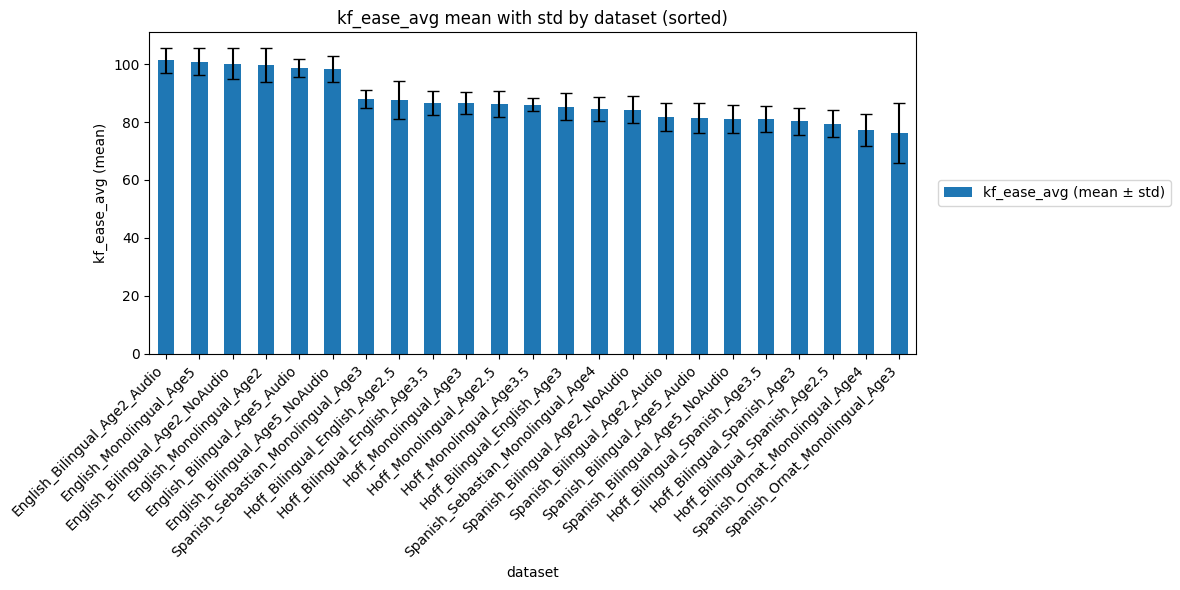

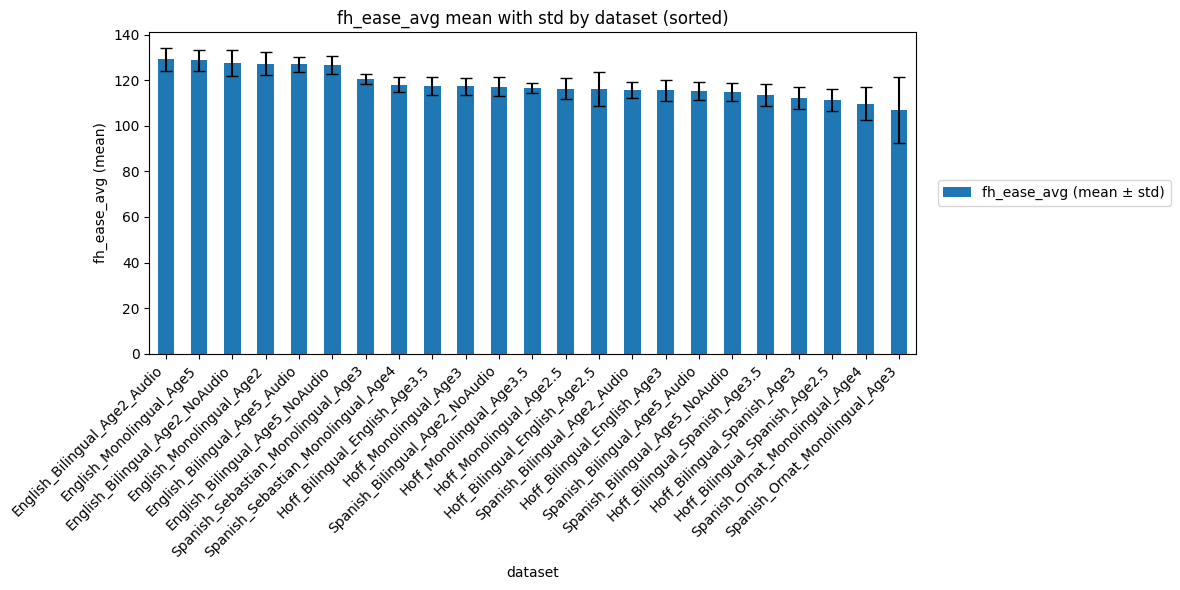

In [19]:
import matplotlib.pyplot as plt

def make_plot(column_name, ascending=False):
    means = grouped_df[(column_name, 'mean')]
    stds = grouped_df[(column_name, 'std')]
    df_plot = pd.DataFrame({'mean': means, 'std': stds}).sort_values('mean', ascending=ascending)

    fig, ax = plt.subplots(figsize=(14,6))
    df_plot['mean'].plot(kind='bar', yerr=df_plot['std'], capsize=4, ax=ax, color='C0', label=f'{column_name} (mean ± std)')

    ax.set_ylabel(f'{column_name} (mean)')
    ax.set_title(f'{column_name} mean with std by dataset (sorted)')
    ax.set_xticklabels(df_plot.index, rotation=45, ha='right')

    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# Sort descending by default (highest mean first). Set ascending=True for lowest-first.
make_plot("kf_ease_avg", ascending=False)
make_plot("fh_ease_avg", ascending=False)

In [20]:
import re
import pandas as pd

def parse_dataset(ds):
    parts = ds.split('_')
    info = {}
    
    
    # splitting bilinguals from monolinguals
    if 'Bilingual' in parts:
        info['group'] = 'bilingual'
    elif 'Monolingual' in parts:
        info['group'] = 'monolingual'
    else:
        info['group'] = 'unknown'
    
    # splitting spanish and english
    if 'English' in parts:
        info['language'] = 'English'
    elif 'Spanish' in parts or 'Spanish' in ds:
        info['language'] = 'Spanish'
    else:
        info['language'] = 'Unknown'
    
    # In case we wanna see results by age
    age_part = [p for p in parts if p.startswith('Age')]
    if age_part:
        age_str = age_part[0].replace('Age', '')
        try:
            info['age_years'] = float(age_str)
        except ValueError:
            info['age_years'] = np.nan
    else:
        info['age_years'] = np.nan
    
    return pd.Series(info)

meta = data_df['dataset'].apply(parse_dataset)
data_df = pd.concat([data_df, meta], axis=1)

In [21]:
data_df

,dataset,filename,plain_utterances,scores,kf_ease,fh_ease,languages,kf_ease_avg,fh_ease_avg,lang_most,group,language,age_years
0,English_Bilingual_Age2_Audio,11221425.cha,['the boy and the dog were looking at the frog...,"[""English_Bilingual_Age2_Audio"", ""11221425.cha...","[103.625, 115.13000000000002, 103.54, 116.1450...","[130.64000000000001, 139.7, 131.18, 140.72, 10...","['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en...",100.113504,128.804432,en,bilingual,English,2.0
1,English_Bilingual_Age2_Audio,11222222.cha,"['the boy went to sleep .', 'and the frog jump...","[""English_Bilingual_Age2_Audio"", ""11222222.cha...","[117.16000000000003, 103.70000000000002, 103.0...","[141.74, 130.99333333333334, 131.1285714285714...","['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en...",107.633048,134.322984,en,bilingual,English,2.0
2,English_Bilingual_Age2_Audio,11222306.cha,['one night the boy and the dog were looking a...,"[""English_Bilingual_Age2_Audio"", ""11222306.cha...","[103.00500000000001, 103.04428571428575, 103.7...","[129.6, 131.12857142857143, 130.99333333333334...","['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en...",101.228104,129.348600,en,bilingual,English,2.0
3,English_Bilingual_Age2_Audio,12122227.cha,"['the dog and the boy is sleeping .', 'the fro...","[""English_Bilingual_Age2_Audio"", ""12122227.cha...","[103.04428571428575, 92.965, 80.30636363636367...","[131.12857142857143, 123.68, 113.8018181818181...","['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en...",100.278569,129.532460,en,bilingual,English,2.0
4,English_Bilingual_Age2_Audio,12222013.cha,"['there was this boy .', ""he got a a pet that'...","[""English_Bilingual_Age2_Audio"", ""12222013.cha...","[118.17500000000001, 95.955, 90.99000000000004...","[142.76, 124.60000000000001, 123.78, 122.55714...","['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en...",90.425742,113.723915,en,bilingual,English,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,Spanish_Sebastian_Monolingual_Age4,04h.cha,"['había una rana , no ?', 'un niño un perro y ...","[""Spanish_Sebastian_Monolingual_Age4"", ""04h.ch...","[75.87500000000001, 78.87285714285717, 45.6450...","[112.76, 113.98571428571428, 90.72, 123.78, 11...","['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en...",80.909066,116.168645,en,monolingual,Spanish,4.0
642,Spanish_Sebastian_Monolingual_Age4,04i.cha,"['está mirando la rana .', 'que está jugando c...","[""Spanish_Sebastian_Monolingual_Age4"", ""04i.ch...","[33.57500000000002, 102.045, 66.40000000000003...","[82.76, 130.72, 105.74000000000001, 105.414285...","['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en...",85.423825,119.118688,en,monolingual,Spanish,4.0
643,Spanish_Sebastian_Monolingual_Age4,04j.cha,"['aquí que había visto una rana .', 'y que un ...","[""Spanish_Sebastian_Monolingual_Age4"", ""04j.ch...","[87.94500000000002, 83.32000000000004, 65.7250...","[120.72, 117.74000000000001, 102.56, 118.64, 1...","['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en...",82.585759,116.250622,en,monolingual,Spanish,4.0
644,Spanish_Sebastian_Monolingual_Age4,04k.cha,['la rana se había metido aquí en el jarrón de...,"[""Spanish_Sebastian_Monolingual_Age4"", ""04k.ch...","[78.24500000000002, 66.10000000000002, 94.3000...","[112.64, 104.32666666666668, 124.3266666666666...","['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en...",87.546406,120.148937,en,monolingual,Spanish,4.0


In [7]:
import pandas as pd
import numpy as np

# English info
df_en = data_df[
    (data_df["language"] == "English") &
    (data_df["group"].isin(["monolingual", "bilingual"]))
].copy()

df_en_mono = df_en[df_en["group"] == "monolingual"]["kf_ease_avg"].dropna()
df_en_bi   = df_en[df_en["group"] == "bilingual"]["kf_ease_avg"].dropna()

print("N English monolingual:", len(df_en_mono))
print("N English bilingual:", len(df_en_bi))


# Spanish info
df_es = data_df[
    (data_df["language"] == "Spanish") &
    (data_df["group"].isin(["monolingual", "bilingual"]))
].copy()

df_es_mono = df_es[df_es["group"] == "monolingual"]["fh_ease_avg"].dropna()
df_es_bi   = df_es[df_es["group"] == "bilingual"]["fh_ease_avg"].dropna()

print("N Spanish monolingual:", len(df_es_mono))
print("N Spanish bilingual:", len(df_es_bi))


N English monolingual: 48
N English bilingual: 238
N Spanish monolingual: 44
N Spanish bilingual: 257


In [8]:
comparison_en = pd.DataFrame({
    "Group": ["English Monolingual", "English Bilingual","Spanish Monolingual", "Spanish Bilingual"],
    "N samples": [len(df_en_mono), len(df_en_bi),len(df_es_mono), len(df_es_bi)],
    "Mean": [df_en_mono.mean(), df_en_bi.mean(), df_es_mono.mean(), df_es_bi.mean()],
    "Std": [df_en_mono.std(), df_en_bi.std(), df_es_mono.std(),df_es_bi.std()]
})
comparison_en

,Group,N samples,Mean,Std
0,English Monolingual,48,100.385390,5.129588
1,English Bilingual,238,92.057468,8.112899
2,Spanish Monolingual,44,114.323321,9.500694
3,Spanish Bilingual,257,113.437319,4.882151


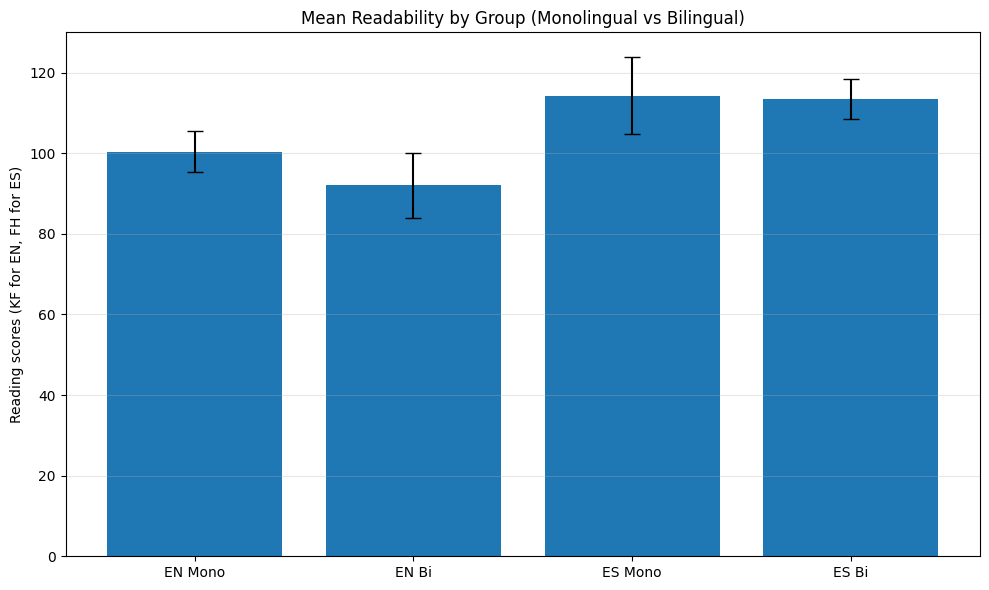

In [10]:
import matplotlib.pyplot as plt
import numpy as np

groups = ["EN Mono", "EN Bi", "ES Mono", "ES Bi"]
means = [
    df_en_mono.mean(),
    df_en_bi.mean(),
    df_es_mono.mean(),
    df_es_bi.mean()
]
stds = [
    df_en_mono.std(),
    df_en_bi.std(),
    df_es_mono.std(),
    df_es_bi.std()
]

plt.figure(figsize=(10,6))
bars = plt.bar(groups, means, yerr=stds, capsize=6)

plt.ylabel("Reading scores (KF for EN, FH for ES)")
plt.title("Mean Readability by Group (Monolingual vs Bilingual)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



In [9]:
from scipy.stats import ttest_ind
import numpy as np
# simnple t-test and effect size
def cohens_d(a, b):
    return (a.mean() - b.mean()) / np.sqrt((a.std()**2 + b.std()**2)/2)

def print_group_stats(name, group1, group2):
    t_res = ttest_ind(group1, group2, equal_var=False)
    d = cohens_d(group1, group2)

    print(f"\n{name}")
    print(f"t-test:        t = {t_res.statistic:.3f}, p = {t_res.pvalue:.3e}")
    print(f"Cohen's d:     d = {d:.3f}")

print_group_stats("English tests", df_en_mono, df_en_bi)
print_group_stats("Spanis htests", df_es_mono, df_es_bi)



English tests
t-test:        t = 9.170, p = 5.901e-15
Cohen's d:     d = 1.227

Spanis htests
t-test:        t = 0.605, p = 5.480e-01
Cohen's d:     d = 0.117
